In [35]:
# Install all required libraries — only need to run this once ever
%pip install pandas numpy scikit-learn xgboost shap matplotlib seaborn streamlit

print("✅ Done!")


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
✅ Done!


In [36]:
# 2. Import Libraries
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

sns.set_style('whitegrid')
print("✅ Libraries loaded!")

✅ Libraries loaded!


In [37]:
# 3. Load CSV 
#skip row index 1 because it's a metadata tag row, not real data
df = pd.read_csv('data/wfp_food_prices_lka.csv', skiprows=[1])

print(f"Rows: {len(df):,}")
print(f"Columns: {df.columns.tolist()}")
df.head(3)

Rows: 22,588
Columns: ['date', 'admin1', 'admin2', 'market', 'market_id', 'latitude', 'longitude', 'category', 'commodity', 'commodity_id', 'unit', 'priceflag', 'pricetype', 'currency', 'price', 'usdprice']


,date,admin1,admin2,market,market_id,latitude,longitude,category,commodity,commodity_id,unit,priceflag,pricetype,currency,price,usdprice
0,2004-01-15,Western,Colombo,Colombo City,368,6.93,79.85,cereals and tubers,Rice (red nadu),157,KG,actual,Retail,LKR,32.71,0.33
1,2004-02-15,Western,Colombo,Colombo City,368,6.93,79.85,cereals and tubers,Rice (red nadu),157,KG,actual,Retail,LKR,33.62,0.34
2,2004-03-15,Western,Colombo,Colombo City,368,6.93,79.85,cereals and tubers,Rice (red nadu),157,KG,actual,Retail,LKR,32.92,0.34


In [38]:
# 4 — Explore the Data
# See what provinces, commodities and date range we have
print("Provinces:")
print(df['admin1'].dropna().unique())

print("\nCategories:")
print(df['category'].dropna().unique())

print(f"\nDate range: {df['date'].min()} → {df['date'].max()}")
print(f"\nPrice stats (LKR):")
df['price'].describe()

Provinces:
['Western' 'Eastern' 'Northern' 'Central' 'North Central' 'North Western'
 'Sabaragamuwa' 'Southern' 'Uva']

Categories:
['cereals and tubers' 'miscellaneous food' 'non-food' 'pulses and nuts'
 'vegetables and fruits' 'meat, fish and eggs' 'oil and fats']

Date range: 2004-01-15 → 2025-09-15

Price stats (LKR):


count    22588.000000
mean       601.125075
std        622.551318
min         16.000000
25%        182.000000
50%        336.000000
75%        864.317500
max       3735.420000
Name: price, dtype: float64

In [39]:
# 5 — Clean the Data
# Keep columns including latitude/longitude and pricetype for richer features
df = df[['date', 'admin1', 'market', 'category', 'commodity', 'unit', 'price', 'latitude', 'longitude', 'pricetype']].copy()

# Filter to RETAIL prices only (ignore wholesale)
print(f"Price types in dataset: {df['pricetype'].value_counts().to_dict()}")
df = df[df['pricetype'] == 'Retail'].copy()
print(f"✅ Filtered to Retail only — removed wholesale records")

# Drop rows with missing prices
before = len(df)
df.dropna(subset=['price'], inplace=True)
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df.dropna(subset=['price'], inplace=True)
print(f"Removed {before - len(df):,} rows with missing prices → {len(df):,} remain")

# Remove extreme outliers — prices above 99th percentile are likely errors
upper = df['price'].quantile(0.99)
before = len(df)
df = df[df['price'] <= upper]
print(f"Removed {before - len(df):,} outliers (above LKR {upper:.2f})")

# Fill missing lat/lon with market-level averages (if any are missing)
for col in ['latitude', 'longitude']:
    missing = df[col].isna().sum()
    if missing > 0:
        market_avg = df.groupby('market')[col].transform('mean')
        df[col].fillna(market_avg, inplace=True)
        print(f"Filled {missing} missing {col} values with market averages")

print(f"\n✅ Clean dataset: {len(df):,} rows (retail prices only)")

Price types in dataset: {'Retail': 22165, 'Wholesale': 423}
✅ Filtered to Retail only — removed wholesale records
Removed 0 rows with missing prices → 22,165 remain
Removed 222 outliers (above LKR 2555.20)
Filled 121 missing latitude values with market averages
Filled 121 missing longitude values with market averages

✅ Clean dataset: 21,943 rows (retail prices only)


In [40]:
# 6 — Extract Date Features
df['date']  = pd.to_datetime(df['date'])
df['year']  = df['date'].dt.year
df['month'] = df['date'].dt.month

print(f"Year range: {df['year'].min()} – {df['year'].max()}")
print(f"Sample:")
df[['date', 'year', 'month', 'price']].head(5)

Year range: 2004 – 2025
Sample:


,date,year,month,price
0,2004-01-15,2004,1,32.71
1,2004-02-15,2004,2,33.62
2,2004-03-15,2004,3,32.92
3,2004-03-15,2004,3,26.63
4,2004-04-15,2004,4,32.98


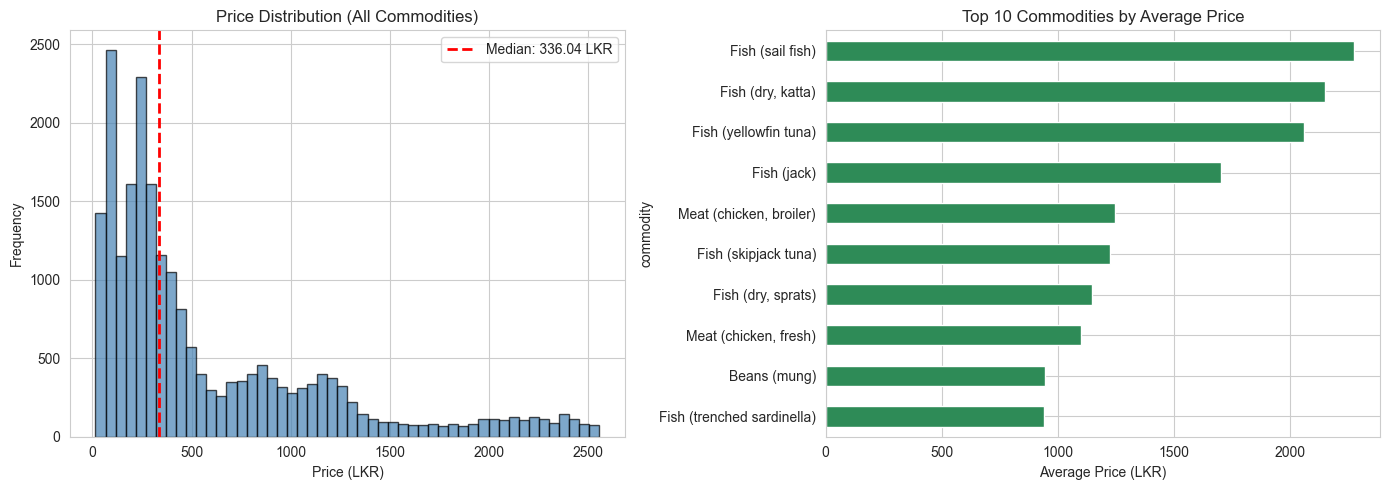

✅ Saved: outputs/eda_price_distribution.png


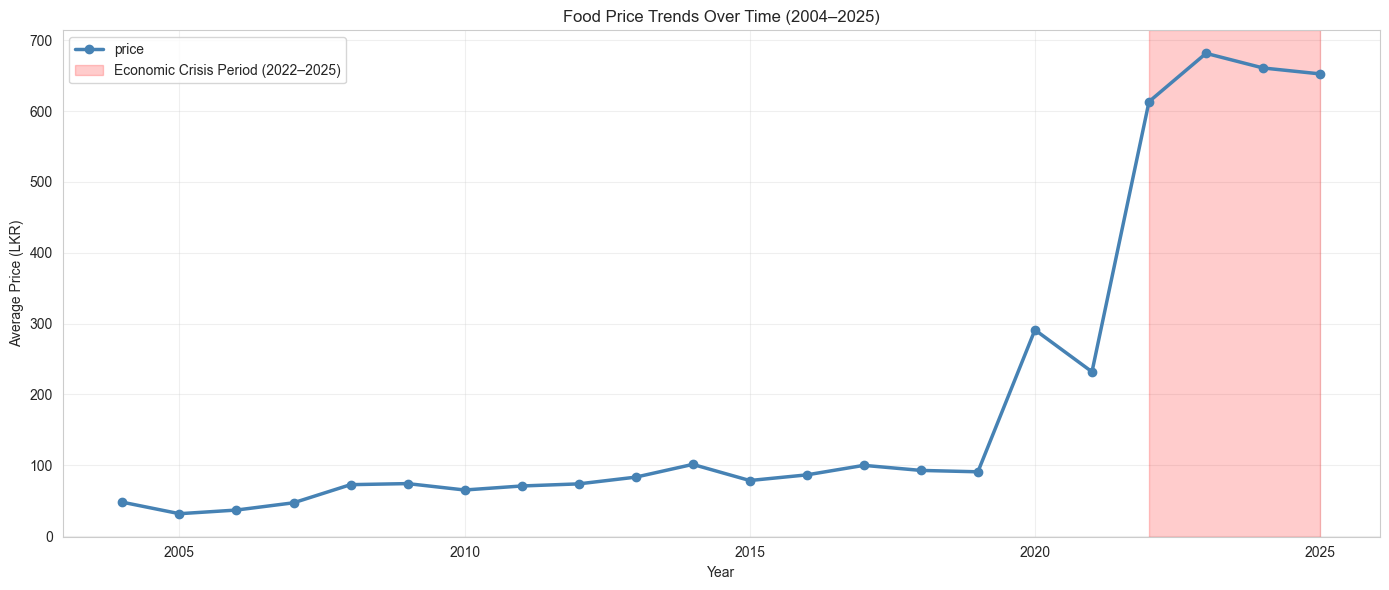

✅ Saved: outputs/eda_price_trend.png


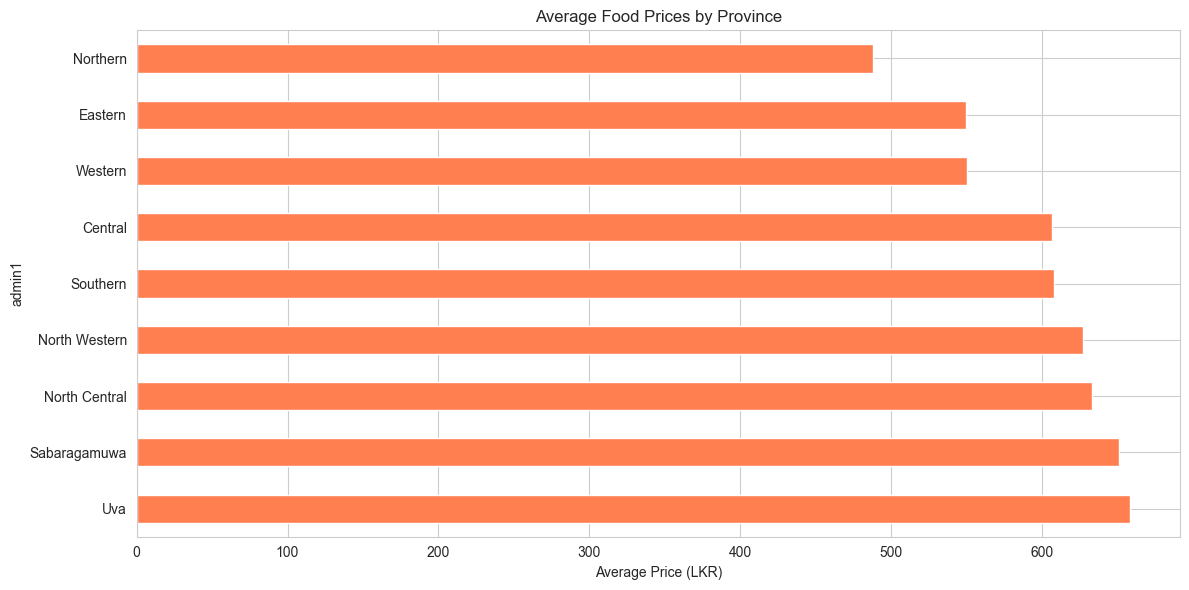

✅ Saved: outputs/eda_province_prices.png

📊 EDA Summary:
   Price range: LKR 16.00 – 2555.00
   Commodities: 42
   Provinces: 9
   Markets: 43
   Date range: 2004-01-15 00:00:00 to 2025-09-15 00:00:00


In [41]:
# 📊 EXPLORATORY DATA ANALYSIS (EDA) — Understand the data before cleaning

# Price distribution by commodity
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Price distribution
ax1 = axes[0]
df['price'].hist(bins=50, ax=ax1, color='steelblue', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Price (LKR)')
ax1.set_ylabel('Frequency')
ax1.set_title('Price Distribution (All Commodities)')
ax1.axvline(df['price'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {df["price"].median():.2f} LKR')
ax1.legend()

# Plot 2: Top 10 commodities by average price
ax2 = axes[1]
top_commodities = df.groupby('commodity')['price'].mean().nlargest(10).sort_values()
top_commodities.plot(kind='barh', ax=ax2, color='seagreen')
ax2.set_xlabel('Average Price (LKR)')
ax2.set_title('Top 10 Commodities by Average Price')

plt.tight_layout()
plt.savefig('outputs/eda_price_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Saved: outputs/eda_price_distribution.png")

# Price over time — showing the 2022 Sri Lanka economic crisis
fig, ax = plt.subplots(figsize=(14, 6))
yearly_avg = df.groupby('year')['price'].mean()
yearly_avg.plot(ax=ax, marker='o', color='steelblue', linewidth=2.5, markersize=6)
ax.axvspan(2022, 2025, alpha=0.2, color='red', label='Economic Crisis Period (2022–2025)')
ax.set_xlabel('Year')
ax.set_ylabel('Average Price (LKR)')
ax.set_title('Food Price Trends Over Time (2004–2025)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('outputs/eda_price_trend.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Saved: outputs/eda_price_trend.png")

# Price by province — geographic variation
fig, ax = plt.subplots(figsize=(12, 6))
province_price = df.groupby('admin1')['price'].mean().sort_values(ascending=False)
province_price.plot(kind='barh', ax=ax, color='coral')
ax.set_xlabel('Average Price (LKR)')
ax.set_title('Average Food Prices by Province')
plt.tight_layout()
plt.savefig('outputs/eda_province_prices.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Saved: outputs/eda_province_prices.png")

print(f"\n📊 EDA Summary:")
print(f"   Price range: LKR {df['price'].min():.2f} – {df['price'].max():.2f}")
print(f"   Commodities: {df['commodity'].nunique()}")
print(f"   Provinces: {df['admin1'].nunique()}")
print(f"   Markets: {df['market'].nunique()}")
print(f"   Date range: {df['date'].min()} to {df['date'].max()}")

In [42]:
# Prepare data for encoding
# Just sort by date for consistency
df = df.sort_values('date')

print("✅ Data sorted!")

✅ Data sorted!


In [43]:
# 8 — Label Encode Categorical Columns
# LabelEncoder converts each unique text value to a unique integer
# e.g. "Western" → 0, "Eastern" → 1, "Northern" → 2

cat_cols = ['admin1', 'market', 'category', 'commodity', 'unit']
encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    df[col + '_enc'] = le.fit_transform(df[col].astype(str))
    encoders[col] = le  # save so we can reverse it in the frontend
    print(f"{col}: {len(le.classes_)} unique values")

print("\n✅ Encoding complete!")
print(df[['admin1', 'admin1_enc', 'commodity', 'commodity_enc', 'price']].head(5))

admin1: 10 unique values
market: 43 unique values
category: 7 unique values
commodity: 42 unique values
unit: 4 unique values

✅ Encoding complete!
    admin1  admin1_enc        commodity  commodity_enc  price
0  Western           8  Rice (red nadu)             35  32.71
1  Western           8  Rice (red nadu)             35  33.62
2  Western           8  Rice (red nadu)             35  32.92
3  Western           8      Wheat flour             41  26.63
4  Western           8  Rice (red nadu)             35  32.98


In [44]:
# 9 — Save Processed Data & Encoders
# Save cleaned data for the training notebook
df.to_csv('outputs/processed_data.csv', index=False)

# Save encoders so the frontend can decode user selections
with open('models/encoders.pkl', 'wb') as f:
    pickle.dump(encoders, f)

print("✅ Saved: outputs/processed_data.csv")
print("✅ Saved: models/encoders.pkl")
print(f"\nFinal dataset shape: {df.shape}")
print(f"Price range: LKR {df['price'].min():.2f} – {df['price'].max():.2f}")
print(f"\nFeatures in dataset:")
print(df.columns.tolist())

✅ Saved: outputs/processed_data.csv
✅ Saved: models/encoders.pkl

Final dataset shape: (21943, 17)
Price range: LKR 16.00 – 2555.00

Features in dataset:
['date', 'admin1', 'market', 'category', 'commodity', 'unit', 'price', 'latitude', 'longitude', 'pricetype', 'year', 'month', 'admin1_enc', 'market_enc', 'category_enc', 'commodity_enc', 'unit_enc']
